In [1]:
import sys
import os.path
sys.path.append('src/util')

import set_compiler
set_compiler.install()

import pyximport
pyximport.install()

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('src')
from OnlineVariationalInference.ovi import oviLDA
from CollapsedGibbsSampler.cgs import cgsLDA
from LDAutil import Evaluation

import time

Compiling with /usr/local/bin/clang-omp


# Introduction

More and more text contents are shared on internet: news article, blog posts, user reviews... All these texts carry relevant information but the issue is how to process them. They could be used in machine learning models to refine prediction. 

For example, one popular application are the recommender systems used by Netflix, Yelp, and numerous other companies. The goal here is to find what the users are more likely to like based on what the people similar to them liked. If we consider movies, we would like to use the synopsis, for products on online stores, we would like to use their descriptions. We could represent the text with its word counts in a [document, term] matrix. But this representation does not depict the underlying structure of the documents and their inner relationships.

One possible solution to this problem is to apply a Latent Dirichlet Allocation, a topic modeling algorithm to find the latent features of the documents. Unfortunately, these methods requires huge computation for large datasets. There is one serial implementation in python (https://pypi.python.org/pypi/lda) which already takes 50 minutes to run for a small document term matrix of size (2000 docs, 10 000 words).

The goal of our project is to implement an LDA package in Python implementing the two most common inference methods: the gibbs sampler and the online variatonnal inference. We took advantage of the Cython and Multithreading modules to build an optimized and parallel algorithm. Our deliverable is an open-source library, fully documented, easy to install and much faster than the current tools.

To tackle this problem, we have to deal with optimizing performance in Cython and parallel design. Once that is complete, we need to cleanly bring the different methods together into a functional package.

In this report, we first provide the theoretical background needed to grasp the algorithm and explain the data we considered to test our algorithm. Then, we present the design of our package, dig deeper into the algorithm implementation and provide our performance results, in terms both of execution time and model accuracy. Lastly, we expose the possible improvements for the future.


# 1 Theory

### 1.1 LDA Model

The LDA is a three-level hierarchical Bayesian model. The basic idea is that documents are represented as random mixtures over latent topics and each topic is characterized by a distribution over words.

The generative process for a document w in a corpus D is the following:

1. Choose the topics representation: $\phi \sim$ Dir($\beta$)
* Choose the number of words: $ N \sim $ Poisson($ \xi $)
* Choose the distribution of topics: $\theta_w \sim$ Dir($\alpha_w$)
* For each of the N words:
    1. Choose a topic assignement: $z_{n,w} \sim \text{Multinomial}(\theta_w)$
	* Choose a word: $w_n \sim \text{ Multinomial}(\phi_{z_{n,w}})$



### 1.2 Inference methods

The main issue relies in computing the posterior distribution of the hidden variables given a document:

\begin{align*}
p(\theta, \mathbf{z} |\mathbf{w}, \alpha, \beta) = \frac{p(\theta, \mathbf{z}, \mathbf{w} | \alpha, \beta)}{p(\mathbf{w} | \alpha, \beta)}
\end{align*}

This distribution is intractable. As mentioned above, we used two  methods to infer it: Gibbs sampling and variational inference. In the first case, we are estimating the hyper parameters $\theta$ and $\phi$ with samples on the different variables. Alternatively, we chose the online variational inference method which finds the variational parameters that optimize a lower bound on the loglikelihood. 

##### 1.2.1 Gibbs sampling

We used the dynamic Gibbs sampling technique detailed in article 1 of References. Let $D$ be the set of documents, $V$ the set of types in the corpus. For any document $d$, type $v$, let's define $n_{dv}$ to be the number of tokens. The model inputs are:

$K$ - the number of topics

$df$ - the damping factor, a parameter used for dynamic sampling

$\alpha$ - hyperparameter associated with documents

$\beta$ - hyperparameter associated with topics

$N$ - number of iterations
    
Let's define $DK$ as the document/topics matrix and $KV$ as the topics/types matrix. We also have $S$, a three-dimensional matrix where for each document/type combination we have a vector keeping a count over how many unique topics were generated from previous iterations. Initially, $S[d][v][n_{dv}] = df$ for all $d \in D, v \in V$. For every word in the corpus, we randomly assign it to a topic. In the case of our code, we have a running counter $count$ of the words we've traversed and we initially assign the topic to $count\%K$. We then increment the corresponding elements in $DK$ and $KV$ that are associated with that document, topic, and type. Then for each iteration $N$:

<img src="img/cgs_pseudocode.png" width=600 height=400/>

##### 1.2.2 Online Variational Inference

The setup of the Variational Inference is as follows. We first approximate the true posterior by a simpler and factorised distribution:
$$q(\boldsymbol{z},\boldsymbol{\theta},\boldsymbol{\beta}) = q(\boldsymbol{z})q(\boldsymbol{\theta})q(\boldsymbol{\beta}) $$ 

where:
$$ q(z_{di} = k) = \phi_{d_{w_{di}k}} \quad q(\theta_d) = \text{Dir}(\theta_d,\gamma_d) \quad q(\beta_k) = \text{Dir}(\beta_k,\lambda_k) $$

The $\boldsymbol{\gamma}$ parameter rules the topic assignments for each document and the $\boldsymbol{\lambda}$, the topics themselves. We then minimise the KL divergence between the distribution $q$ and the true posterior $p$ like for the usual variational inference. What differs in online variational inference is that we sample a batch of document at each step and perform the E-step as if this batch constituted the entire corpus. 

We present the algorithm below:

<img src="img/ovi_pseudocode.png" width=500 height=300/>

where $\kappa \in (0.5,1]$ rules how fast we forget old values of $\tilde{\lambda}$ and $\tau_{0}$ how much weight one wants to put on the first iterations. 


### 1.3 Evaluation methods

We need a measure to evaluate the performance of our model and to tune the hyperparameters. We use perplexity on held-out data as a measure of our model fit. Perplexity is defined as the geometric mean of the log likelihood of the words in the held-out set of documents given the trained model. In our case, for each document we held out 20% of the words which constitute the test set.

\begin{align*}
	perplexity(D_{test}) & = \frac{\sum\limits_{d \in D_{test}} \log p(words)}{\sum\limits_{d \in D_{test}|d|}}\\
	perplexity(D_{test}) & = \frac{\sum\limits_{d \in D_{test}} \sum\limits_{w \in d} \log \left( \sum_{t \in topics} p(w|t)p(t|d) \right)}{\sum\limits_{d \in D_{test}|d|}}
\end{align*}



# 2 Data

### 2.1 Presentation

We chose to apply the latent dirichlet allocation on user reviews from the Yelp website. We focused only on the restaurants from a specific city (Las Vegas). The objective is to infer both the restaurant categories present in Las Vegas (using the topic distribution provided by the lda) and the categories for each restaurant (using the topics assignement of each restaurant).

We download the raw data made available by Yelp for its dataset challenge competition (http://www.yelp.com/dataset_challenge). For the Las Vegas restaurants, we have ~20 000 reviews of average size ~100 words, the set of unique words being larger than 50 000.


### 2.2 Processing

The dataset contains 3822 businesses, considered here as documents. Cleaning the reviews represented a significant part of this final project. We present some of the steps we followed in the process:\\

* We aggregated all the reviews about a particular business into a "super" review, in order to get a general sense of what the restaurant was about;
* We applied spelling corrections, removed common stopwords and generic words such as "table" or "restaurants";
* We attempted at only selecting common words and not adjectives in order to focus on what the venues were about and not the users' opinions (this process was done taking advantage of Spark to reduce the computing time);
* We transformed the corpus of "super reviews" into a document-term matrix that we could exploit.
* We aggregated reviews so some words may be more prevalent than others but normalized the words counts into the range [0, 100]. 

The processing lead to a document term matrix of size (2 000 words, 10 000 documents)


# 3 Package design

We worked hard on building a very well organized and documentation package. The documentation is provided in the readme file on the github repository : https://github.com/virgodi/plda


# 4 Implementation Details

### 4.1 OVI

The online variational inference implementation implies a single pass of the algorithm on each document. The only parallelisation is feasible on the loop over the documents is using mini-batch of documents and updating the topics distribution between these batch. As a result, we chose to implement a mini-batch version where the work inside the batch is divided among threads. 

We first wrote a functional version in Cython without using any Python library (like numpy) to be able to release the gil. To parallelise the work among threads, we needed to find an efficient combination of shared and private memories between the threads.

#### Cython code

The main focus was to rewrite every matrix operations and computations without any Python object. We chose to use the typed memoryviews which allow efficient access to memory buffers without incurring any Python overhead. The operations on matrix were done column wisely to take advantage of the data location in memory.

In the optimization problem solved, we need to use the digamma function which is the logarithm derivative of the gamma function. This method is implemented in scipy. We needed to implement it in cython autonomously. We chose to rely on a Taylor approximation which provide the right result with an average of 10e-8 in the range used.


#### Multithreading

As mentioned above, we used Python’s threading package to parallelise the OVI algorithm. For every document in a minibatch, we need to evaluate both the $\gamma$’s and the $\phi$’s and use these values to fill in the temporary topic matrix $\tilde{\lambda}$ that will then be used to update the global topic matrix. Parallelising the minibatch might therefore caused issues when each thread need to write back in this temporary topic matrix when words are present in multiple documents. To resolve this issue, we first thought about having each thread lock the matrix before writing in it. But this method ended up being too expensive. We therefore chose to initialise for every minibatch a list of temporary topic matrix, one for each document of the minibatch. We passed this list as an argument to the worker. Each thread can now write back to a specific matrix and avoid corruption. We then needed to combine all these matrices together using a sum. This method may be more expensive memorywise than the locking approach, but showed promising time improvements.

We also tried implementing a method where we divide the vocabulary into regions with locks and each threads works on one region at a time. They can write back in the temporary topic matrix only in the columns of their region with the lock. But this method was not feasible as the update of the gamma relies on an estimation over the whole vocabulary at each step of the inner loop. A locking approach by topics is not feasible either as we need to normalise over all the words when updating the $phi$’s.


### 4.2 CGS

We provide Cython functions on initializing the topics and carrying out N iterations of Gibbs sampling over specified documents and words. Using these functions we provide two parallel methods - these methods correspond to setting split_words to True or False. The model also takes an input sync_interval, which will be explained below.

#### split_words = False:    

This is the default implementation. The documents are split evenly among the threads. Each thread iterates through only those documents when performing the Gibbs sampling. Since there may be race conditions over the gamma matrix, each thread stores a local copy to update. Every sync_interval iterations, each thread calculates the difference between the global and local gamma - then it either waits on the specified Condition object or if it's the last thread to enter this block it will notify each thread that the differences have all been calculated. Then, each thread will add their differences to the global gamma again one at a time and wait. Once the last thread adds its differences, the global gamma is synced and each thread will copy it to their local gamma and continue the sampling. Increasing the sync_interval will increase the speed, but results will be less accurate as the individual threads will lose the topic information from the other documents.
        
#### split_words = True:

If the corpus is large, storing a local gamma matrix is incredibly wasteful. This approach not only splits by documents, but splits the types V into even blocks according to the number of threads as well - V_1, V_2, ... V_threads. Each block of types has an associated lock - to calculate over the block of words the thread needs to acquire the lock. In each iteration of Gibbs sampling, thread i will start on V_i, acquire it's associated lock and start sampling. When it's completed it's block of words over it's associated documents, it will try to acquire the lock of the next block of words, blocking if needed. Using these locks, we guarantee that no two threads access the same word at the same time, so race conditions are prevented from the global gamma matrix. For small datasets, the locking costs outweigh the benefit of synchronizing local matrices, but for our Las Vegas dataset we saw that this performed better. This approach was based off link 2 in the References section. Their pseudocode implies they wait for all threads to finish calculating their respective type blocks until moving to the next one, where as we utilize locks to have the threads move asynchronously.

# Result

We have two datasets to work with - a smaller Reuters dataset provided in the Python lda package and our cleaned Las Vegas data.

We first want to test speed on our different parallelization methods across both data sets and see how they scale.

Next, we run a cross-validation on the number of topics and calculate perplexity measures

In [2]:
# Loading the data: too heavy to be on github, a zip file has been attached in lasvegas folder
# Be sure to unzip the dtm file and adjust the relative location of the file
import numpy as np
dtm = np.load('lasvegas/lv_dtm.npy').astype(np.dtype('i'))
# Data for cross validation
dtm_train = np.load('lasvegas/dtm_lv_train.npy').astype(np.dtype('i'))
dtm_test = np.load('lasvegas/dtm_lv_test.npy').astype(np.dtype('i'))
vocablv = np.load('lasvegas/lv_vocab10.npy')
reutdtm = np.load('reuters/dtm.npy').astype(np.dtype('i'))
reutvoc = np.load('reuters/vocab.npy')

## Speed

In [3]:
# Let's run our models on 4,8,16 threads to get an idea of speedup over
# reuters and lasvegas data sets
def speed_test(model_name, model):
    threads = [4,8,16]
    reut_speeds = []
    lv_speeds = []
    for t in threads:
        model.set_num_threads(t)
        start = time.time()
        model.fit(reutdtm)
        reut_speeds.append(time.time()-start)
        start = time.time()
        model.fit(dtm)
        lv_speeds.append(time.time()-start)
    fig, ax = plt.subplots()
    ax.plot(threads, reut_speeds, 'r--', label='Reuters')
    for tl in ax.get_yticklabels():
        tl.set_color('r')
    ax2 = ax.twinx()
    ax2.plot(threads, lv_speeds, 'b--', label='Las Vegas')
    for tl in ax2.get_yticklabels():
        tl.set_color('b')
    

    legend = ax.legend(loc='upper left', shadow=True)
    legend2 = ax2.legend(loc='upper right', shadow=True)

    frame = legend.get_frame()
    frame.set_facecolor('0.90')

    for label in legend.get_texts():
        label.set_fontsize('large')

    for label in legend.get_lines():
        label.set_linewidth(1.5)
        
    ax.set_ylim([0, max(reut_speeds)*1.4])
    ax2.set_ylim([0, max(lv_speeds)*1.4])
    ax.set_xlabel('Threads')
    ax.set_ylabel('Time (s)', color='r')
    ax2.set_ylabel('Time (s)', color='b')
    plt.title("Fit speeds for " + model_name)
    plt.show()

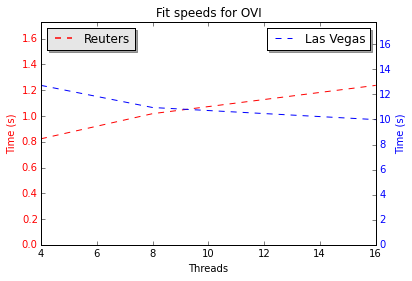

In [4]:
#1000 max iterations
model_ovi = oviLDA(num_topics=40, num_threads=16, batch_size=50)
speed_test("OVI", model_ovi)

OVI is a faster algorithm by nature, only iterating through each document once. Still, you see some speedups over the large Las Vegas data. With Reuters, the overhead of creating new threads is probably larger than the actual runtime.

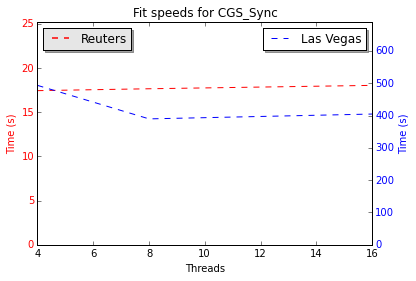

In [5]:
model_cgs = cgsLDA(num_topics=40, num_threads=16, iterations=1500, sync_interval=5, split_words = False)
speed_test("CGS_Sync", model_cgs)

This is the sync method - the topics/words matrices are stored locally on each thread and copied after every 5 iterations (sync_interval = 5). With the Reuters data, it seems we've reached the speedup capable - the locking required to synchronize outways our parallelism. However, we do get a nice speedup from 4 to 8 threads on the Las Vegas dataset. Let's see see what the limit of our speedup is if we don't sync at all.

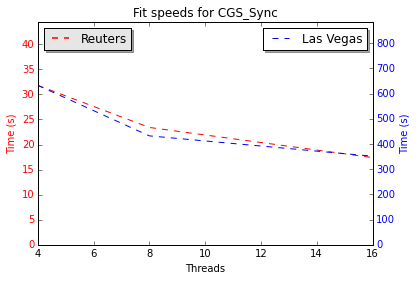

In [4]:
model_cgs.set_sync_interval(1500)
speed_test("CGS_Sync", model_cgs)

As expected increasing the sync_interval speeds the process up a bit - but it's a slippery slope. More iterations are only using an accurate distribution over a subset of documents, so depending on the sparsity of your corpus the results may be rather poor. In that case it's important to analyze the perplexity of your results, which we will demonstrate below.

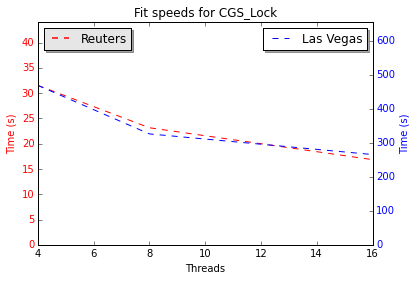

In [6]:
#now let's compare our second parallel method
model_cgs.set_sync_interval(5)
model_cgs.set_split_words(True)
speed_test("CGS_Lock", model_cgs)

This is the lock method - the topics/words are both split with locking to avoid storing a local copy of the topics-words matrix. This is a pretty good speedup! Note that the Reuters performs slower here than in the sync version, but in the case with the Las Vegas data it performs as well or better, and scales better as well. Given the size of the dataset which parallelism we choose differs.

In [4]:
# Speed baselines
# Some compiler incompatibility
# will need to restart and rerun without the set_compiler command
import lda
import time
lda = lda.LDA(n_topics = 40, n_iter=1500)
start = time.time()
lda.fit(reutdtm)
print "Baseline for Reuters data is:{}".format(time.time() - start)
start = time.time()
lda.fit(dtm)
print "Baseline for Las Vegas data is:{}".format(time.time() - start)

Baseline for Reuters data is:65.8305959702
Baseline for Las Vegas data is:2357.78971004


Compared to the existing lda package, our methods outperform quite a bit!

## Perplexity

In [3]:
# Cross validation on the number of topics
def cv(model_name, model, steps=5):
    K = range(40, 101, steps)
    perplexity_dict = {}
    for k in K:
        model.set_topics(k)
        %time model.fit(dtm_train)
        perplexity_dict[k] = Evaluation.perplexity(model, dtm_test)
    perp_val = sorted(perplexity_dict.items(), key=lambda x: x[0])
    plt.plot([p[0] for p in perp_val], [p[1] for p in perp_val])
    plt.xlabel('Number of topics')
    plt.ylabel('Perplexity')
    plt.title('Cross validation for ' + model_name)
    plt.show()
    
#clean the data in case there are rows/columns of all 0's
def remove_zeros(arr):
    zero_index = []
    for i in range(arr.shape[0]):
        if np.sum(arr[i]) == 0:
            zero_index.append(i)
    new_arr = np.zeros((arr.shape[0] - len(zero_index), arr.shape[1]), dtype=np.dtype("i"))
    new_idx = 0
    for i in range(arr.shape[0]):
        if i not in zero_index:
            new_arr[new_idx] = arr[i]
            new_idx += 1
    for i in range(new_arr.shape[1]):
        if np.sum(new_arr[:, i]) == 0:
            new_arr[:, i] = np.ones((new_arr.shape[0]))
    return new_arr

CPU times: user 1min 3s, sys: 1.47 s, total: 1min 5s
Wall time: 18.2 s
CPU times: user 1min 8s, sys: 1.66 s, total: 1min 10s
Wall time: 19.9 s
CPU times: user 1min 25s, sys: 1.94 s, total: 1min 27s
Wall time: 24.7 s
CPU times: user 1min 33s, sys: 2.05 s, total: 1min 35s
Wall time: 26 s
CPU times: user 1min 50s, sys: 2.31 s, total: 1min 52s
Wall time: 31 s
CPU times: user 2min 6s, sys: 2.55 s, total: 2min 8s
Wall time: 34.2 s
CPU times: user 2min 6s, sys: 2.64 s, total: 2min 9s
Wall time: 35.2 s
CPU times: user 2min 29s, sys: 2.98 s, total: 2min 32s
Wall time: 41.1 s
CPU times: user 2min 18s, sys: 3.11 s, total: 2min 22s
Wall time: 37.2 s
CPU times: user 2min 30s, sys: 3.38 s, total: 2min 33s
Wall time: 41.1 s
CPU times: user 3min, sys: 3.74 s, total: 3min 3s
Wall time: 47.6 s
CPU times: user 2min 55s, sys: 3.92 s, total: 2min 59s
Wall time: 47.4 s
CPU times: user 3min 10s, sys: 3.86 s, total: 3min 13s
Wall time: 51.3 s


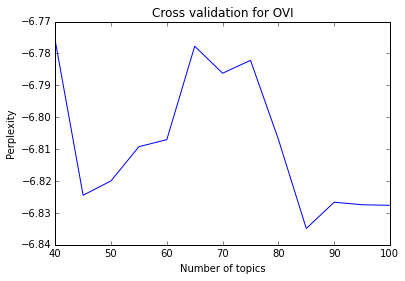

In [4]:
model_ovi = oviLDA(num_topics=40, num_threads=16, batch_size=50)
cv("OVI", model_ovi)

We see a very nice plateau of the OVI perplexity.

In [5]:
#clean data for gibbs sampling, can't have rows/columns of 0
dtm_test = remove_zeros(dtm_test)
dtm_train = remove_zeros(dtm_train)

CPU times: user 20min 49s, sys: 7.52 s, total: 20min 57s
Wall time: 2min 52s
CPU times: user 30min 18s, sys: 8.03 s, total: 30min 26s
Wall time: 4min 3s
CPU times: user 39min 48s, sys: 9.62 s, total: 39min 58s
Wall time: 5min 18s
CPU times: user 49min 28s, sys: 12.3 s, total: 49min 40s
Wall time: 6min 38s


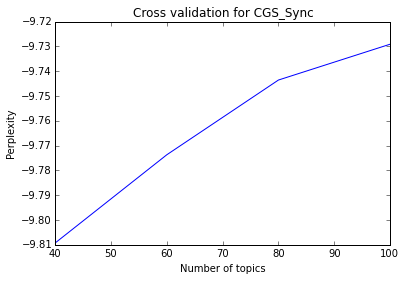

In [6]:
model_cgs = cgsLDA(num_topics=40, num_threads=16, iterations=500, sync_interval=5, split_words = False)
cv("CGS_Sync", model_cgs, 20)

CPU times: user 12min 35s, sys: 5.77 s, total: 12min 41s
Wall time: 1min 42s
CPU times: user 17min 15s, sys: 6.04 s, total: 17min 21s
Wall time: 2min 18s
CPU times: user 22min 15s, sys: 6.57 s, total: 22min 22s
Wall time: 2min 58s
CPU times: user 27min 30s, sys: 6.59 s, total: 27min 36s
Wall time: 3min 36s


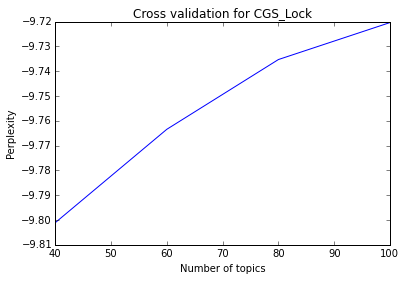

In [7]:
model_cgs.set_split_words(True)
cv("CGS_Lock", model_cgs, 20)

There isn't a clear plateau with CGS - further tests would require higher iteration counts. In literature it's roughly 1500 iterations. Note the wall times of split_words = True runs, as topics increases this parallelizes better as well.

# 5 Improvements

For the Online Variational Inference, we are still not entirely satisfied with the chosen method to avoid corruption. Indeed, when working with a very large vocabulary and/or fitting an LDA model with large number of topics, this method could become extremely intense memorywise because we need to create a local copy of the topics array for each thread.  Fixing this aspect of the code would be a great addition to the package.

The Gibbs sampling is currently divided up evenly by number of documents and number of types. If there are 12 documents and you want 4 threads, each thread gets 3 documents. If there are 100 types in the corpus it'd get split up into groups of 25 if split_words is set to True. A better way to divide up the documents and types would be by the number of tokens - if one document has many more tokens than another, they should not be treated equally. Likewise if a group of tokens are heavily used they should be split evenly among the threads.

# 6 Learnings

Testing the Online Variational Inference method, we realised that this algorithm is extremely sensitive to the hyperparametrisation, i.e the batch size $S$, the forgetfullness parameter $\kappa$ and the early iterations weith parameter $\tau$. This was also noted by Tamara Broderick, Nicholas Boyd, Andre Wibisono and Ashia C. Wilson in their paper [Streaming Variational Bayes](http://papers.nips.cc/paper/4980-streaming-variational-bayes.pdf). In addition to validating the number of topics, validating over these parameters was crucial to obtain valuable results. By parallelising the algorithm, we allow for a great gain in time when fitting the optimum LDA model for a particular corpus.

As there were two Gibbs sampling parallelization methods, it was interesting to see how each one performed under small and large data sets. Using the reuters data (which can be found in the reuters folder), the preferred method was storing a local copy of gamma. Since it was relatively small the synchronization costs weren't as great as if there was locking between the types. However, we found the locking method preferable for the las vegas dataset.

Finally, building a Python package from scratch was also an interesting experience. It was important for us to learn how to work independently on different parts of the code but forcing us at the same time to have some uniformisation. Having two independent classes that have individual specificities but share a number of common methods is a great example of that. We definitely feel that this project helped us develop our software engineering skills.

# References

1. <a href="http://jmlr.csail.mit.edu/proceedings/papers/v13/xiao10a/xiao10a.pdf">Dynamic Gibbs Sampling</a>
2. <a href="https://www.cs.purdue.edu/homes/alanqi/papers/Parallel-Inf-LDA-GPU-NIPS.pdf">Parallel CGS</a>
3. [Online Learning for Latent Dirichlet Allocation](https://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf)